<a href="https://colab.research.google.com/github/eduardoplima/rl-imd/blob/main/Deep_Q_Learning_CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q-Learning for Cart Pole (PyTorch)

In this notebook, we will use Deep Q-Learning to solve Cart Pole.


Environment: (https://gymnasium.farama.org/environments/classic_control/cart_pole/).

Paper: (https://arxiv.org/abs/1312.5602).

##Setup

In [ ]:
%%capture
!pip install gymnasium
!pip install numpy
!pip install imageio imageio_ffmpeg
!pip install pyvirtualdisplay
!apt-get install -y xvfb
!apt-get install -y python-opengl ffmpeg
!pip install pytorch

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

Importing PyTorch neural network (torch.nn) and optimizer (torch.optim)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

## Setup a Virtual Display
To generate a replay video of agent and environment.

In [ ]:
# Virtual display
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [ ]:
# Let's start by creating the Cart Pole environment.
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.spec

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, disable_env_checker=False, kwargs={'render_mode': 'rgb_array'}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

##Observing the environment

In [ ]:
# actions: push cart to the left=0, push cart to the right = 1
actions = ["push cart to the left", "push cart to the right"]
print ("Actions:", actions)

Actions: ['push cart to the left', 'push cart to the right']


In [ ]:
def plot_image(plot, render, size):
  plot.figure(figsize=(14, 5))
  plot.xticks(range(size))
  plot.yticks(range(size))
  plot.imshow(render, extent=[0, size, size, 0])
  plot.show()

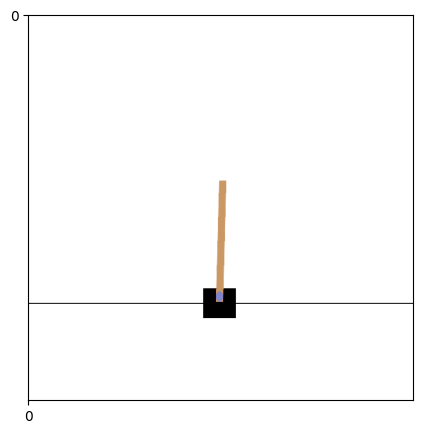

In [ ]:
# This sets the initial state at S, our starting point
# We can render the environment to see where we are on the cartpole gridworld
env.reset()
img = env.render()
plot_image(plt,img,1)

##Executing random actions

In [ ]:
# Taking a step by selecting a random action[move left=0, move down = 1, move right = 2, move up = 3] from current state
# next_observation: position on the grid
# reward: What rewards did I receive?
# is_terminal: did I end up in the goal state?

print("step number: [x cart position, x cart velocity, pole angle (rad), pole angular velocity], reward, terminated, truncated, {info}")

for i in range(20):
    # sample a random action from all valid actions
    action = env.action_space.sample()

    state, reward, terminated, truncated, info = env.step(action)
    is_terminal = terminated or truncated

    print("step", i+1, ":", action, ",", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
    if(is_terminal):
        break

step number: [x cart position, x cart velocity, pole angle (rad), pole angular velocity], reward, terminated, truncated, {info}
step 1 : 0 , push cart to the left , [-0.01071967 -0.22258323  0.04168775  0.32024968] , 1.0 , False , False , {}
step 2 : 1 , push cart to the right , [-0.01517134 -0.028079    0.04809274  0.04099947] , 1.0 , False , False , {}
step 3 : 0 , push cart to the left , [-0.01573292 -0.22385642  0.04891273  0.34845987] , 1.0 , False , False , {}
step 4 : 1 , push cart to the right , [-0.02021005 -0.02946304  0.05588193  0.07159316] , 1.0 , False , False , {}
step 5 : 0 , push cart to the left , [-0.02079931 -0.22533977  0.05731379  0.38137034] , 1.0 , False , False , {}
step 6 : 1 , push cart to the right , [-0.0253061  -0.03107649  0.0649412   0.10729492] , 1.0 , False , False , {}
step 7 : 1 , push cart to the right , [-0.02592763  0.16305763  0.0670871  -0.16421314] , 1.0 , False , False , {}
step 8 : 0 , push cart to the left , [-0.02266648 -0.03295735  0.06380

In [ ]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
before_training = "before_training.mp4"
video = VideoRecorder(env, before_training)

# returns an initial observation
state, info = env.reset()
env.render()
video.capture_frame()

for i in range(100):
    action = env.action_space.sample()

    state, reward, terminated, truncated, info = env.step(action)
    is_terminal = terminated or truncated

    env.render()
    video.capture_frame()

    if(is_terminal):
        print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
        break

video.close()

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 29 : push cart to the right , [-0.16985989 -0.6128782   0.22731633  1.1611004 ] , 1.0 , True , False , {}


In [ ]:
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [ ]:
from IPython.display import HTML
html = render_mp4(before_training)
HTML(html)

##Building a Deep Q-learning agent (off-policy)

![alt_text](https://drive.google.com/uc?id=1zH2nQKEgT--Mm2-8zrepEue0I2aggWhk)

##Experience Replay Buffer

We will use **Experience Replay** in order to store the agent's experiences in the form $(s_t, a_t, r_t, s_{t+1})$:
- **state** $s_t$ in which the agent was in
- **action** $a_t$ the agent selected in that state
- **reward** $r_t$ received for taking the action in the state
- **next state** $s_{t+1}$ that the agent arrived to after action

After collecting a number **N** of these tuples $(s_t, a_t, r_t, s_{t+1})$, we randomly pass the data to train network.

In [ ]:
class ReplayBuffer:
    def __init__(self, max_length, observation_space_n):

        self.index, self.size, self.max_length = 0, 0, max_length

        self.states = np.zeros((max_length, observation_space_n), dtype=np.float32)
        self.actions = np.zeros((max_length), dtype=np.uint8)
        self.rewards = np.zeros((max_length), dtype=np.float32)
        self.next_states = np.zeros((max_length, observation_space_n), dtype=np.float32)
        self.dones = np.zeros((max_length), dtype=np.uint8)

    def __len__(self):
        return self.size

    def update(self, state, action, reward, next_state, is_terminal):
        # Update the Replay Buffer
        self.states[self.index] = state
        self.actions[self.index] = action
        self.rewards[self.index] = reward
        self.next_states[self.index] = next_state
        self.dones[self.index] = is_terminal

        self.index = (self.index + 1) % self.max_length
        if self.size < self.max_length:
            self.size += 1

    def sample(self, batch_size):
        # Pick indexes randomly from the Replay Buffer
        idxs = np.random.randint(0, self.size, size=batch_size)

        return (self.states[idxs], self.actions[idxs], self.rewards[idxs], self.next_states[idxs], self.dones[idxs])

## Linear Neural Network

A linear neural network to be used with Deep Q-learning algoritmh. It is useful for environments where we are not receiving an image as observation.

The input size of the network receives an input of the available environment states.

The output of the network is the Q-value for each available action. So the output size is the shape of the actions state.

The size of the hidden layers is arbitrary. So, it can be varied from one application to another and it is one of the parameters that are worth modifying to ensure greater efficiency in the network.

In [ ]:
class LinearNetwork(nn.Module):
    """
    Linear neural network for Q-learning and SARSA
    """
    def __init__(self, state_size, hidden_size, action_size):
        super(LinearNetwork, self).__init__()

        # These lines establish the feed-forward part of the neural network used to choose actions
        # Input layer with (one unit for each state variable)
        self.input_layer = nn.Linear(state_size, hidden_size)

        # Hidden layer with a number of hidden neurons
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)

        # Output layer (one unit for each action)
        self.output_layer = nn.Linear(hidden_size, action_size)

        print("Artificial neural network started with PyTorch")
        print("input =", state_size, ", Hidden =", hidden_size, ", output =", action_size)

    # Called with either one element to determine the action
    # Returns tensor([[left0exp,right0exp]...]).
    def forward(self, state):
        # Passing the state through the input layer
        x = self.input_layer(state)

        # Passing the input layer output through the hidden layer
        x = torch.relu(self.hidden_layer(x))

        # Passing the hidden layer output through the output layer
        return self.output_layer(x)

## Deep Q-learning Agent

In [ ]:
class DeepQLearningAgent:

    def __init__(
        self,
        alpha_learning_rate,
        gamma_discount_factor,
        initial_epsilon,
        epsilon_decay,
        final_epsilon,
        state_space,
        hidden_size,
        action_space,
        device,
        model,
        optimizer,
        criterion,
        batch_size,
        max_memory
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            alpha_learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            gamma_discount_factor: The discount factor for computing the Q-value
            state_space: The state space
            action_space: The action space
            batch_size: The sample size for batch
            max_memory: The max number of iterations to be stored in memory buffer
        """
        self.alpha_learning_rate = alpha_learning_rate
        self.gamma_discount_factor = gamma_discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.state_space = state_space
        self.hidden_size = hidden_size
        self.action_space = action_space
        self.device = device
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.batch_size = batch_size
        self.max_memory = max_memory
        self.training_error = []

        # Set the seed
        self.rng = np.random.default_rng(123)

        # Initialize experience replay buffer
        self.memory = ReplayBuffer(self.max_memory, self.state_space.shape[0])

        print("Deep Q-learning agent started with PyTorch")

    def eval_state(self, state):
        with torch.no_grad():
            state_tensor = torch.tensor(state, device=self.device, dtype=torch.float32)
            q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()

    def choose_action(self, state):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # First we randomize a number
        exploration_exploitation_tradeoff = self.rng.uniform(0, 1)

        # Exploration
        # with probability epsilon return a random action to explore the environment
        if exploration_exploitation_tradeoff < self.epsilon:
            return self.action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            with torch.no_grad():
                return self.eval_state(state)

    def remember(self, state, action, reward, next_state, is_terminal):
        self.memory.update(state, action, reward, next_state, is_terminal)

    def update(self):
        # If we have less experience than batch size, we don't start training
        if self.batch_size * 10 > self.memory.size:
            return

        # A sample of the training experiences
        (states, actions, rewards, next_states, dones) = self.memory.sample(self.batch_size)

        # Turning the experiences into tensors
        states = torch.as_tensor(states).to(self.device)
        actions = torch.as_tensor(actions).to(self.device).unsqueeze(-1)
        rewards = torch.as_tensor(rewards).to(self.device).unsqueeze(-1)
        next_states = torch.as_tensor(next_states).to(self.device)
        dones = torch.as_tensor(dones).to(self.device).unsqueeze(-1)

        """Updates the neural network weights."""
        # Train the network using target and the predicted q_network values
        # Setting the model in training mode
        self.model.train()

        # Eval state
        Q1 = self.model(states).gather(-1, actions.long())

        # Eval next states
        with torch.no_grad():
            Q2 = self.model(next_states).max(dim=-1, keepdim=True)[0]
            target = (rewards + (1 - dones) * self.gamma_discount_factor * Q2).to(self.device)

        # Computing the loss (error between the predicted Q-value and the actual Q-value)
        temporal_difference_error = self.criterion(Q1, target)
        self.training_error.append(temporal_difference_error.item())

        # Reset accumulated gradients
        self.optimizer.zero_grad()

        # Performing backpropagation
        temporal_difference_error.backward()

        # Updating network parameters
        self.optimizer.step()

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

## Setting hyperparameters and initializing an agent

In [ ]:
alpha_learning_rate = 1e-4 # @param {type:"number"}
nb_max_episodes = 400 # @param {type:"integer"}
start_epsilon = 1.0 # @param {type:"number"}
final_epsilon = 0.1 # @param {type:"number"}
epsilon_decay = (start_epsilon - final_epsilon) / nb_max_episodes  # reduce the exploration over time
gamma_discount_factor = 0.99 # @param {type:"number"}
test_freq = 50 # @param {type:"integer"}
total_steps = 0 # @param {type:"integer"}

batch_size = 64 # @param {type:"integer"}
max_memory = 10000 # @param {type:"integer"}

# Starting the artificial neural network
# Check that there is a GPU avaiable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_size = 64 # @param {type:"integer"}

# Input and output size based on the environment
# These lines establish the feed-forward part of the netwotk used to choose actions
model = LinearNetwork(env.observation_space.shape[0], hidden_size, env.action_space.n).to(device)

# Initialize optimizer that can be SGD, Adam, RMSprop, etc.
optimizer = optim.Adam(model.parameters(), lr=alpha_learning_rate)

# Initialize loss function using mean squared error
criterion = nn.MSELoss()

agent = DeepQLearningAgent(
    alpha_learning_rate=alpha_learning_rate,
    gamma_discount_factor=gamma_discount_factor,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    state_space = env.observation_space,
    hidden_size = hidden_size,
    action_space = env.action_space,
    device = device,
    model = model,
    optimizer = optimizer,
    criterion = criterion,
    batch_size=batch_size,
    max_memory=max_memory
)

Artificial neural network started with PyTorch
input = 4 , Hidden = 64 , output = 2
Deep Q-learning agent started with PyTorch


### Test accurracy

In [ ]:
def test_accurracy(num_steps, num_episodes=100):
    counter = 0
    nb_success = 0.0

    while counter < num_episodes:
        is_terminal = False
        state, info = env.reset()

        for i in range(num_steps):
            action = agent.eval_state(state)
            state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            nb_success += reward

            if(is_terminal):
                break

        counter += 1

    return nb_success/num_episodes

In [ ]:
def record_trained_video(video_file, num_steps):
    video = VideoRecorder(env, video_file)

    # returns an initial observation
    state, info = env.reset()
    env.render()
    video.capture_frame()

    for i in range(num_steps):
        action = agent.eval_state(state)
        state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        env.render()
        video.capture_frame()

        if(is_terminal):
            print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
            break

    video.close()

## Playing and Training

In [ ]:
from tqdm import tqdm
#Create lists to contain total rewards, steps and accurracy per episode
accuracies = []
mean_rewards = []
rewards = []
steps = []

for episode_count in tqdm(range(nb_max_episodes)):
    state, info = env.reset()
    is_terminal = False
    total_reward = 0
    episode_step = 0

    # The Q-Network training
    while not is_terminal:
        episode_step += 1

        # Choose an action by greedily (with epsilon chance of random action) from the Q-Network
        action = agent.choose_action(state)

        # Play best or random move and get new state and reward from environment
        next_state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        # Store experience
        agent.remember(state, action, reward, next_state, is_terminal)

        # Train neural network based on ReplayBuffer
        agent.update()

        # update the current observation
        state = next_state
        total_steps += 1
        total_reward += reward

    agent.decay_epsilon()

    mean_rewards.append(total_reward)
    if (episode_count+1) % test_freq == 0:
        accur = test_accurracy(env.spec.max_episode_steps, 25)
        accuracies.append(accur)

        print('step: %s, episode: %s, training reward mean: %s, test reward mean: %s, random move probability: %s' % (total_steps, episode_count+1, sum(mean_rewards)/test_freq, accur, agent.epsilon))
        mean_rewards.clear()

    rewards.append(total_reward)
    steps.append(episode_step)

after_training = "after_training.mp4"
record_trained_video(after_training, env.spec.max_episode_steps)
env.close()

 13%|█▎        | 53/400 [00:02<00:20, 17.01it/s]

step: 1052, episode: 50, training reward mean: 21.04, test reward mean: 9.52, random move probability: 0.8875000000000013


 26%|██▌       | 103/400 [00:04<00:11, 25.52it/s]

step: 1989, episode: 100, training reward mean: 18.74, test reward mean: 9.28, random move probability: 0.7750000000000026


 38%|███▊      | 151/400 [00:08<00:48,  5.13it/s]

step: 3788, episode: 150, training reward mean: 35.98, test reward mean: 120.92, random move probability: 0.6625000000000039


 50%|█████     | 202/400 [00:15<00:56,  3.48it/s]

step: 6205, episode: 200, training reward mean: 48.34, test reward mean: 154.44, random move probability: 0.5500000000000052


 62%|██████▎   | 250/400 [00:23<01:01,  2.45it/s]

step: 9615, episode: 250, training reward mean: 68.2, test reward mean: 116.92, random move probability: 0.43750000000000644


 75%|███████▌  | 300/400 [00:53<03:02,  1.83s/it]

step: 21286, episode: 300, training reward mean: 233.42, test reward mean: 474.92, random move probability: 0.3250000000000077


 88%|████████▊ | 350/400 [01:23<01:13,  1.46s/it]

step: 33658, episode: 350, training reward mean: 247.44, test reward mean: 397.48, random move probability: 0.21250000000000854


100%|██████████| 400/400 [02:07<00:00,  3.14it/s]

step: 51724, episode: 400, training reward mean: 361.32, test reward mean: 434.16, random move probability: 0.10000000000000844



/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 500 : push cart to the right , [-1.3883151   0.01603339  0.00695049 -0.25798175] , 1.0 , False , True , {}


In [ ]:
# You should get a video similar to the one below.
html = render_mp4(after_training)
HTML(html)

### Metrics

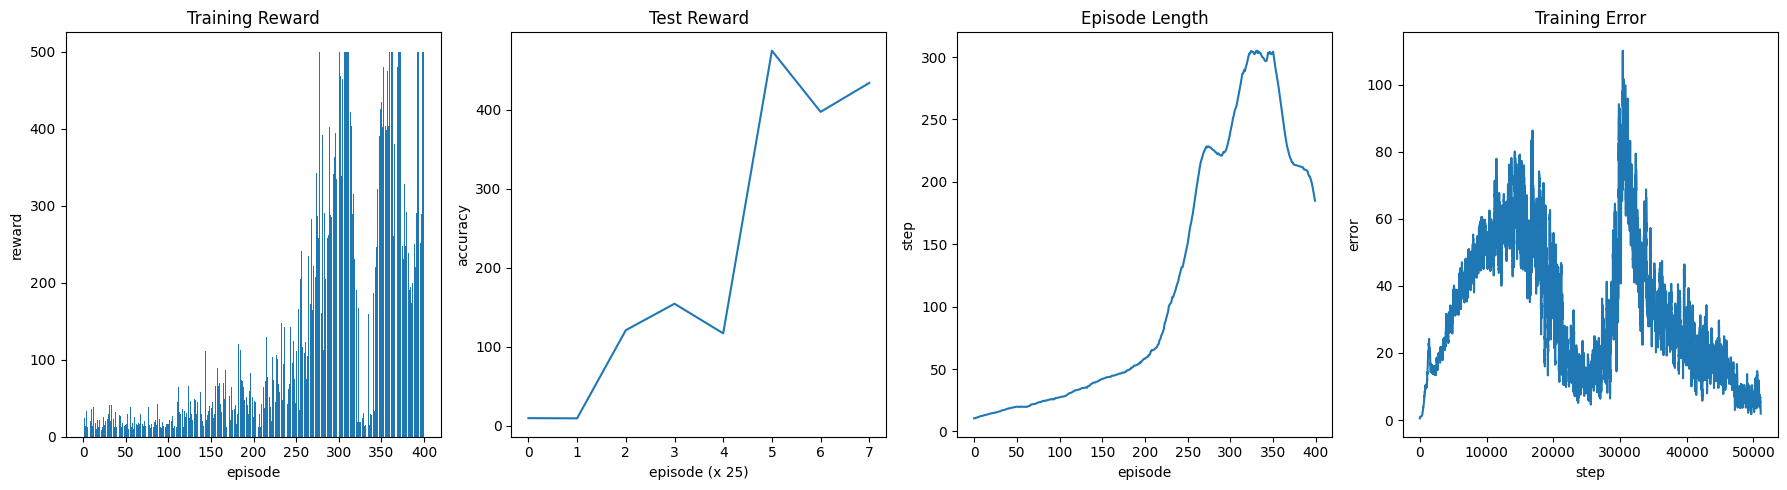

In [ ]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards)), rewards)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 25)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies)), accuracies)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()